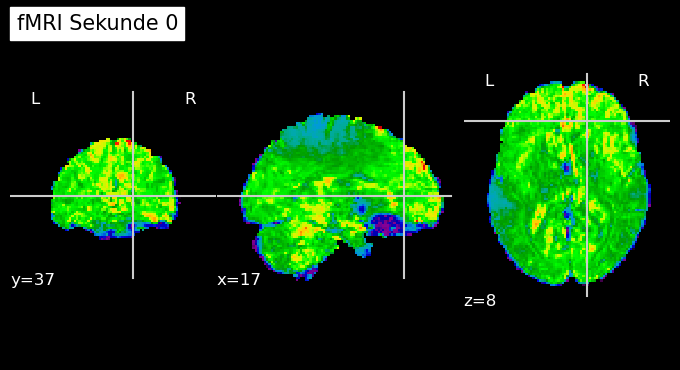

In [12]:
# Bibliotheken importieren
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib  # Für das Lesen von fMRI-Daten
from nilearn import plotting  # Für die Visualisierung der Gehirnaktivität
from nilearn.connectome import ConnectivityMeasure  # Für die Berechnung der Functional Connectomes

# Lade die fMRI-Daten
file_path = "/Users/thomaspfaffinger/Coding/BrainActivity/Datensatz/100307/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR.nii"  # "Pfad_zur_Datei/fMRI_Daten.nii.gz"
fmri_img = nib.load(file_path)

# Visualisiere ein Beispielbild der fMRI-Daten
plotting.plot_epi(fmri_img.slicer[:, :, :, 0], title='fMRI Sekunde 0')



In [13]:
fmri_img.shape

# 1200? in dem Beispiel von nilearn nehmen die nur ein Objekt?!

(91, 109, 91, 1200)

In [39]:
from nilearn import datasets
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels
len(labels) #49 labels -> aber erster Label ist Hintergrund -> nicht relevant => 48 Labels

# DENKE AB HIER FEHLT DER BEZUG ZU UNSEREN DATEN...
# One subject of brain development fMRI data
data = datasets.fetch_development_fmri(n_subjects=1, reduce_confounds=True)
fmri_filenames = data.func[0]
reduced_confounds = data.confounds[0]  # This is a preselected set of confounds


Dataset created in /Users/thomaspfaffinger/nilearn_data/development_fmri


Added README.md to /Users/thomaspfaffinger/nilearn_data/development_fmri


Dataset created in /Users/thomaspfaffinger/nilearn_data/development_fmri/development_fmri



 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


Downloaded 2711552 of 5642698 bytes (48.1%,    1.1s remaining) ...done. (4 seconds, 0 min)


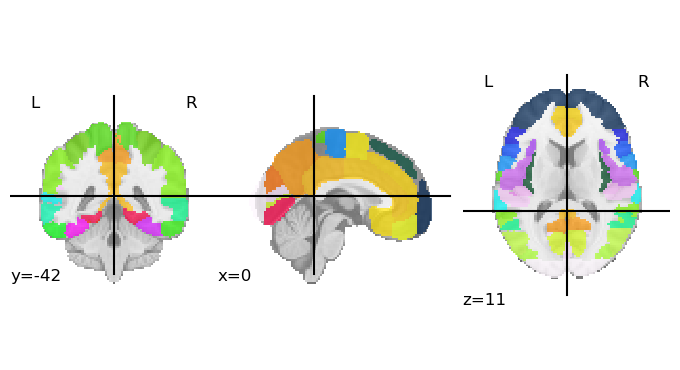

In [40]:
plotting.plot_roi(atlas_filename)

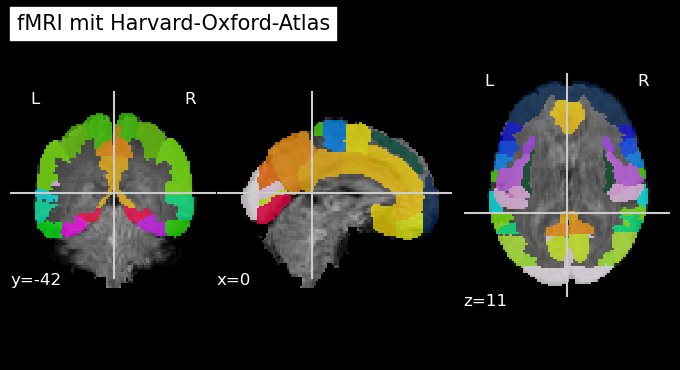

In [41]:
from nilearn import plotting
plotting.plot_roi(atlas_filename, bg_img=fmri_img.slicer[:, :, :, 0], title='fMRI mit Harvard-Oxford-Atlas')

In [42]:
# Anwenden: (masker + confounds => time_series)

from nilearn.maskers import NiftiLabelsMasker
masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
)

time_series = masker.fit_transform(fmri_filenames, confounds=reduced_confounds)



[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/Users/thomaspfaffinger/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
<nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x31ef02310>, { 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x31f038e50>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  '

The shape of the confounds matrix is: (168, 12)
Index(['cosine00', 'cosine01', 'cosine02', 'cosine03', 'csf', 'rot_x', 'rot_y',
       'rot_z', 'trans_x', 'trans_y', 'trans_z', 'white_matter'],
      dtype='object')
[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/Users/thomaspfaffinger/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
<nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x31f060e10>, { 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'kee

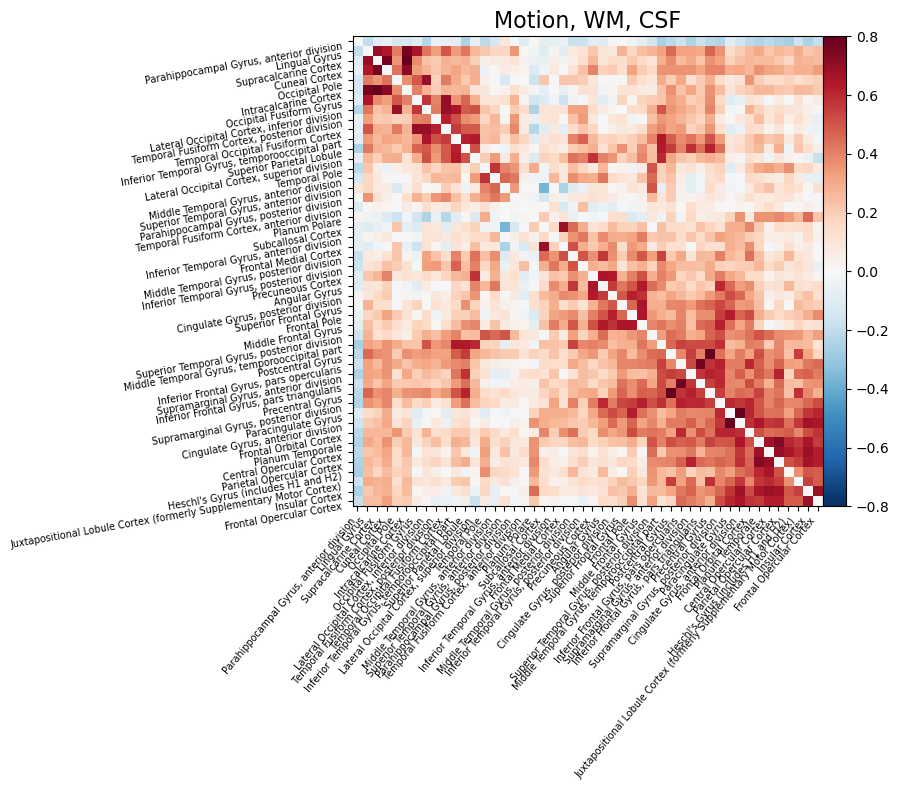

In [43]:
# "confounds=confounds_dataframe" nicht verwendet da bis dato, confounds_dataframe nicht bekannt -> "confounds=None"
#time_series = masker.fit_transform(fmri_img, confounds=None)
#time_series.shape


from nilearn.interfaces.fmriprep import load_confounds

confounds_simple, sample_mask = load_confounds(
    fmri_filenames,
    strategy=["high_pass", "motion", "wm_csf"],
    motion="basic",
    wm_csf="basic",
)

print("The shape of the confounds matrix is:", confounds_simple.shape)
print(confounds_simple.columns)

time_series = masker.fit_transform(
    fmri_filenames, confounds=confounds_simple, sample_mask=sample_mask
)

correlation_matrix = correlation_measure.fit_transform([time_series])[0]

np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(
    correlation_matrix,
    figure=(10, 8),
    labels=labels[1:],
    vmax=0.8,
    vmin=-0.8,
    title="Motion, WM, CSF",
    reorder=True,
)

"**Confounds**" sind Variablen, die potenzielle Störgrößen oder Quellen für Artefakte in den fMRI-Daten repräsentieren können. Diese Variablen werden oft in der fMRI-Analyse verwendet, um Störungen zu kontrollieren oder zu korrigieren, die nicht mit dem eigentlichen interessierenden Signal zusammenhängen.

Typische Confounds in fMRI-Studien können beispielsweise Bewegungsparameter sein (z. B. Rotationen und Translationen des Kopfes während des Scans), Herzschlag- oder Atemfrequenzsignale, globale Signale (z. B. Mittelwert über das gesamte Gehirn) und andere physiologische Signale. Diese Confounds werden oft aus den Daten berechnet oder gemessen und können dann in der Analyse berücksichtigt werden, um die Interpretation der Ergebnisse zu verbessern.

Das Argument confounds in der fit_transform()-Methode des Maskers ermöglicht es, eine Datenstruktur zu übergeben, die diese Confounds enthält. Das NiftiLabelsMasker-Objekt kann dann diese Confounds aus den fMRI-Daten entfernen oder sie bei Bedarf in der Analyse berücksichtigen.

Wenn Sie jedoch Confounds haben und sie verwenden möchten, sollten Sie eine Datenstruktur wie ein Pandas DataFrame erstellen, das diese Confounds enthält, und es als confounds-Argument übergeben:

python:
"time_series = masker.fit_transform(fmri_img, confounds=confounds_dataframe)"

Es ist wichtig zu beachten, dass die Verwendung von Confounds stark von Ihrer spezifischen Analyse abhängt und ob Sie glauben, dass diese Störgrößen Ihre Ergebnisse beeinflussen könnten.

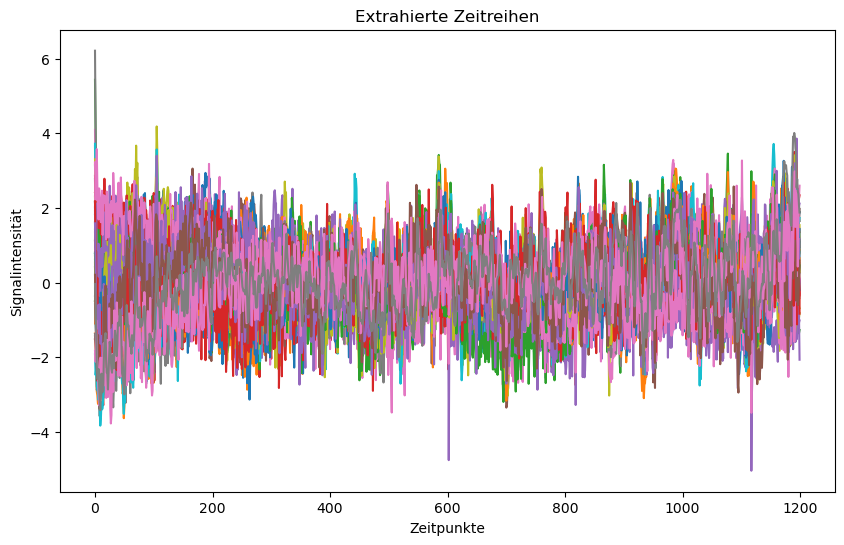

In [18]:
# Annahme: time_series ist ein 2D-Numpy-Array mit den extrahierten Zeitreihen
plt.figure(figsize=(10, 6))
plt.plot(time_series)
plt.xlabel('Zeitpunkte')
plt.ylabel('Signalintensität')
plt.title('Extrahierte Zeitreihen')
plt.show()

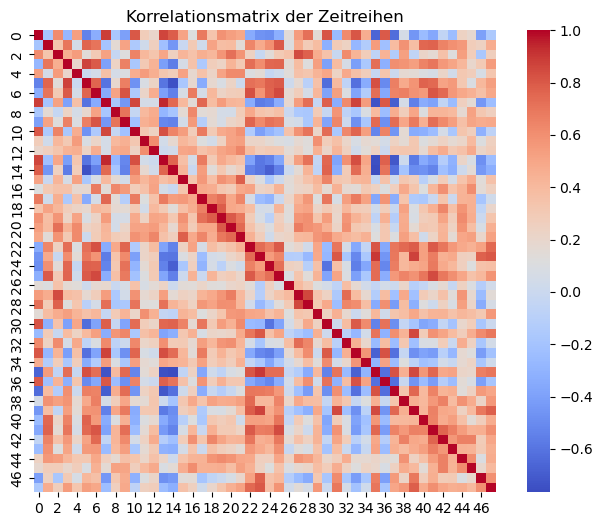

In [23]:
#Heatmap der Korrelationsmatrix: Wenn Sie die funktionelle Konnektivität analysieren, können Sie die Korrelationsmatrix der Zeitreihen visualisieren, 
#um die Beziehung zwischen den verschiedenen Gehirnregionen zu untersuchen:

import seaborn as sns

# Annahme: time_series ist ein 2D-Numpy-Array mit den extrahierten Zeitreihen
correlation_matrix = np.corrcoef(time_series.T)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', square=True)
plt.title('Korrelationsmatrix der Zeitreihen')
plt.show()


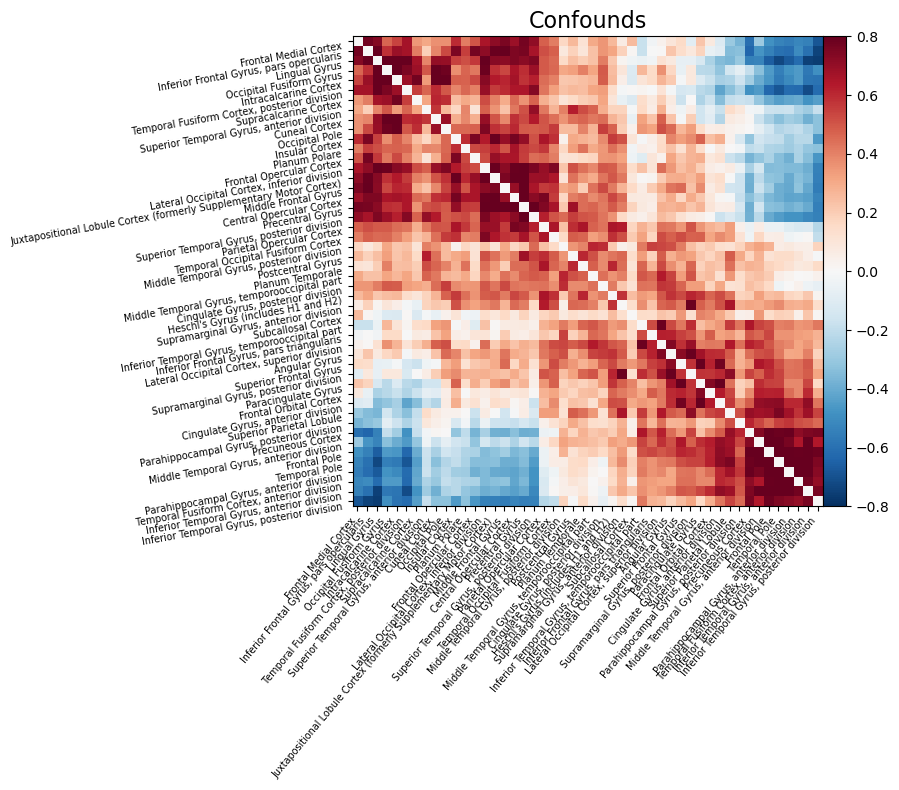

In [28]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)
correlation_matrix = correlation_measure.fit_transform([time_series])[0]


# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the first label
# matrices are ordered for block-like representation
plotting.plot_matrix(
    correlation_matrix,
    figure=(10, 8),
    labels=labels[1:],
    vmax=0.8,
    vmin=-0.8,
    title="Confounds",
    reorder=True,
)

In [ ]:
# Definiere die Regionen des Gehirns für die Connectome-Analyse
atlas = "Pfad_zur_atlas_Datei/atlas.nii.gz"
atlas_img = nib.load(atlas)

# Berechne die Functional Connectomes
connectome_measure = ConnectivityMeasure(kind='correlation')
connectome_data = connectome_measure.fit_transform([fmri_img])

# Visualisiere ein Beispiel-Connectome
plt.figure(figsize=(8, 6))
plt.imshow(connectome_data[0], cmap='viridis', interpolation='nearest')
plt.colorbar(label='Korrelation')
plt.title('Functional Connectome Beispiel')
plt.show()

# Führe statistische Analysen auf den Functional Connectomes durch
# Hier könnten Sie verschiedene Analysen wie Netzwerk-Metriken, Gruppenvergleiche usw. durchführen

